In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Đường dẫn đến các tập dữ liệu
usd_data_path = '/content/drive/MyDrive/dataset/US Dollar Index Futures Historical Data.csv'
bitcoin_data_path = '/content/drive/MyDrive/dataset/Bitcoin Historical Data.csv'
nasdaq_data_path = '/content/drive/MyDrive/dataset/NASDAQ Composite Historical Data.csv'

In [4]:
# Define a function to preprocess each dataset
def preprocess_data(data_path, date_format='%d/%m/%Y'):
  df = pd.read_csv(data_path)
  df = df[::-1] # Reverse the order
  df.fillna(method='ffill', inplace=True)
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
  df['Date'] = pd.to_datetime(df['Date'], format=date_format)
  print(df)
  return df

In [5]:
# Define a function to preprocess each dataset
def preprocess_us_data(data_path, date_format='%m/%d/%Y'):
    df = pd.read_csv(data_path)
    df = df[::-1]  # Reverse the order
    df.fillna(method='ffill', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    print(df)
    return df

In [6]:
# Preprocess each dataset
bitcoin_df = preprocess_data(bitcoin_data_path)
nasdaq_df = preprocess_data(nasdaq_data_path)
usd_df = preprocess_us_data(usd_data_path)

print(bitcoin_df)
print(nasdaq_df)
print(usd_df)

           Date    Price       Open       High        Low    Vol. Change %
4110 2013-03-01     34.5       33.4       34.9       32.9  39.79K    3.36%
4109 2013-03-02     34.3       34.5       34.8       33.2  36.66K   -0.72%
4108 2013-03-03     34.5       34.3       34.5       33.8  12.53K    0.73%
4107 2013-03-04     36.2       34.5       36.7       34.2  46.77K    4.78%
4106 2013-03-05     40.3       36.2       40.7       36.2  85.43K   11.56%
...         ...      ...        ...        ...        ...     ...      ...
4    2024-05-28  68366.0  69,428.30  69,560.70  67,299.90  71.39K   -1.53%
3    2024-05-29  67635.8  68,366.20  68,897.60  67,143.20  52.13K   -1.07%
2    2024-05-30  68354.7  67,631.30  69,504.70  67,138.40  66.84K    1.06%
1    2024-05-31  67530.1  68,352.30  69,018.20  66,676.80  61.51K   -1.21%
0    2024-06-01  67760.8  67,533.90  67,861.00  67,449.60  19.01K    0.34%

[4111 rows x 7 columns]
           Date     Price       Open       High        Low     Vol. Change 

# DATASET BITCOIN

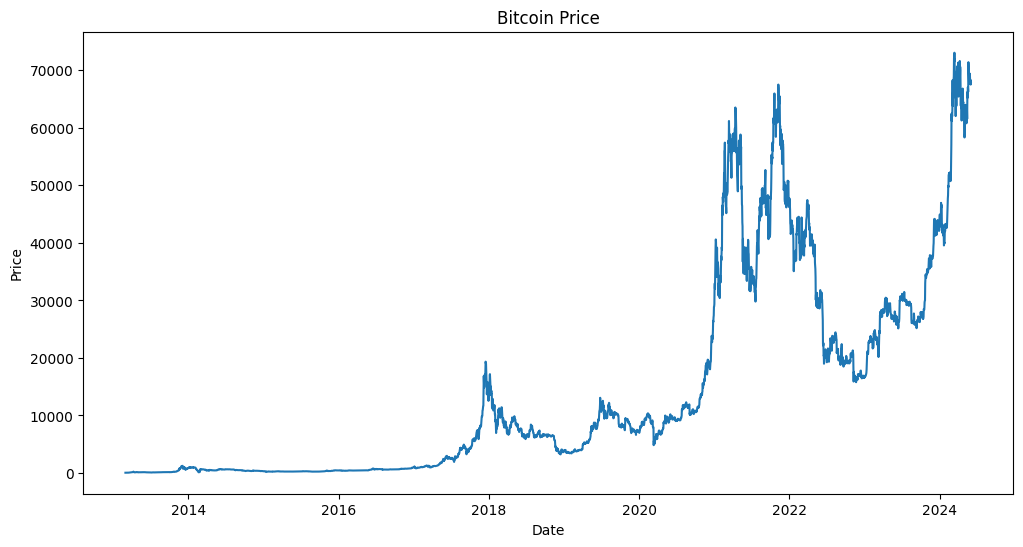

In [7]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(bitcoin_df['Date'], bitcoin_df['Price'])
plt.title('Bitcoin Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET NASDAQ


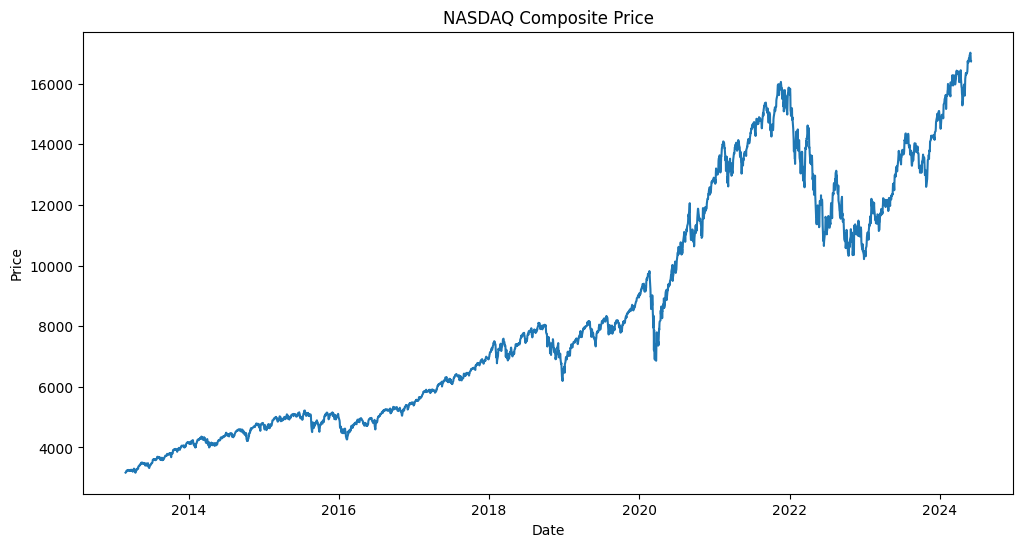

In [8]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_df['Date'], nasdaq_df['Price'])
plt.title('NASDAQ Composite Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# DATASET US Dollar Index

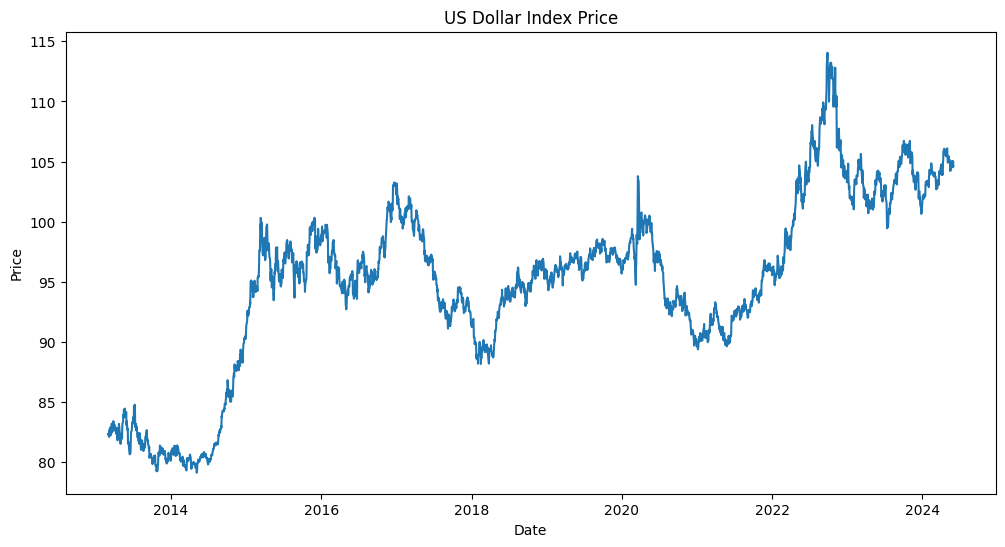

In [9]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(usd_df['Date'], usd_df['Price'])
plt.title('US Dollar Index Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [10]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []

    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
        print(np.array(xs), np.array(ys))
    return np.array(xs), np.array(ys)

In [11]:
# Function to forecast future prices
def forecast_future(model, data, steps, scaler, sequence_length=30):
    last_sequence = data[-sequence_length:].reshape(1, sequence_length, 1)
    forecast = []
    for _ in range(steps):
        prediction = model.predict(last_sequence)
        forecast.append(prediction[0, 0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = prediction[0, 0]
        print(last_sequence)

    forecast = np.array(forecast).reshape(-1, 1)
    forecast_prices = scaler.inverse_transform(forecast)
    print(forecast_prices)
    return forecast_prices.flatten()

In [12]:
# Function to split data into training and testing sets
def split_data(X, y, ratio):
    train_size = int(len(X) * ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print(X_train, X_test, y_train, y_test)
    return X_train, X_test, y_train, y_test

In [13]:
# Function to build the LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

In [14]:
def evaluate_model(y_true, y_pred):
    print(y_true)
    print(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(mae)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(mape)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(rmse)
    return mae, mape, rmse

In [15]:
# Function to process the dataset and plot the results
def process_dataset(df, dataset_name, sequence_length=30, split_ratio=0.8):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['Price']].values)
    X, y = create_sequences(scaled_data, sequence_length)
    X_train, X_test, y_train, y_test = split_data(X, y, split_ratio)

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_model(input_shape)
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1)

    # Predictions
    predicted_prices = model.predict(X_test)

    # Inverse transform to get actual prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    predicted_prices_actual = scaler.inverse_transform(predicted_prices).flatten()

    # Evaluation
    mae, mape, rmse = evaluate_model(actual_prices, predicted_prices_actual)
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAPE: {mape:.2f}%')

    # Forecast future prices
    future_steps = 30
    future_forecast_1 = forecast_future(model, scaled_data, future_steps, scaler)
    future_forecast_2 = forecast_future(model, scaler.transform(future_forecast_1.reshape(-1, 1)), future_steps, scaler)
    future_forecast_3 = forecast_future(model, scaler.transform(future_forecast_2.reshape(-1, 1)), future_steps, scaler)

    # Plot results
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Price'], color='blue', label='Training Data', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], actual_prices, color='orange', label='Actual Price', linestyle='solid')
    plt.plot(df['Date'][len(df) - len(y_test):], predicted_prices_actual, color='green', label='Predicted Price', linestyle='solid')

    future_dates_1 = pd.date_range(df['Date'].iloc[-1], periods=future_steps + 1)[1:]
    future_dates_2 = pd.date_range(future_dates_1[-1], periods=future_steps + 1)[1:]
    future_dates_3 = pd.date_range(future_dates_2[-1], periods=future_steps + 1)[1:]

    plt.plot(future_dates_1, future_forecast_1, color='red', label='Next 30 Days Forecast', linestyle='solid')
    plt.plot(future_dates_2, future_forecast_2, color='yellow', label='Next 60 Days Forecast', linestyle='solid')
    plt.plot(future_dates_3, future_forecast_3, color='brown', label='Next 90 Days Forecast', linestyle='solid')

    plt.title(f'LSTM {dataset_name} Time Series Forecast Ratio {round(split_ratio * 10)}:{round((1 - split_ratio) * 10)}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

# BITCOIN

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.00750356]
 [0.0077336 ]
 [0.00781575]
 [0.00783081]
 [0.00774866]
 [0.00761995]
 [0.00770484]
 [0.00779521]
 [0.00762542]
 [0.00759256]
 [0.0073146 ]
 [0.00750904]
 [0.00777604]
 [0.00771306]
 [0.00776098]
 [0.00822653]
 [0.00833744]
 [0.00837167]
 [0.00826624]
 [0.00807454]
 [0.00806085]
 [0.00811151]
 [0.00793214]
 [0.00795542]
 [0.00806085]
 [0.00799786]
 [0.00819641]
 [0.00823748]
 [0.00812931]
 [0.00799649]
 [0.0080143 ]
 [0.00794857]
 [0.00811014]
 [0.00812247]
 [0.00811562]
 [0.00803346]
 [0.0080896 ]
 [0.008054  ]
 [0.00804305]
 [0.00777194]
 [0.00775277]
 [0.00769115]
 [0.00767746]
 [0.00758024]
 [0.00755148]
 [0.0072612 ]
 [0.00760215]
 [0.00772949]
 [0.00763227]
 [0.00759393]
 [0.00764733]
 [0.00759256]
 [0.00760625]
 [0.00764733]
 [0.00768841]
 [0.00760215]
 [0.00763775]
 [0.00741593]
 [0.00730365]
 [0.00695312]
 [0.00644238]
 [0.00632873]
 [0.00667789]
 [0.00617811]
 [0.00585908]
 [0.00617264]
 [0.00660669]
 [0.0066217

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]
  ...
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[9.56257531e-01]
  [9.52694709e-01]
  [9.76252875e-01]
  ...
  [8.82665133e-01]
  [8.72659930e-01]
  [8.68420692e-01]]

 [[9.52694709e-01]
  [9.76252875e-01]
  [9.53419049e-01]
  ...
  [8.72659930e-01]
  [8.68420692e-01]
  [8.63667981e-01]]

 [[9.76252875e-01]
  [9.53419049e-01]
  [8.95564958e-01]
  ...
  [8.68420692e-01]
  [8.63667981e-01]
  [8.73942929e-01]]] [[8.03757257e-04]
 [9.54376164e-04]
 [1.14607295e-03]
 ...
 [8.63667981e-01]
 [8.73942929e-01]
 [8.30215522e-01]]
[[[2.73852558e-06]
  [0.00000000e+00]
  [2.73852558e-06]
  ...
  [7.10647387e-04]
  [7.69525687e-04]
  [7.92803155e-04]]

 [[0.00000000e+00]
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]


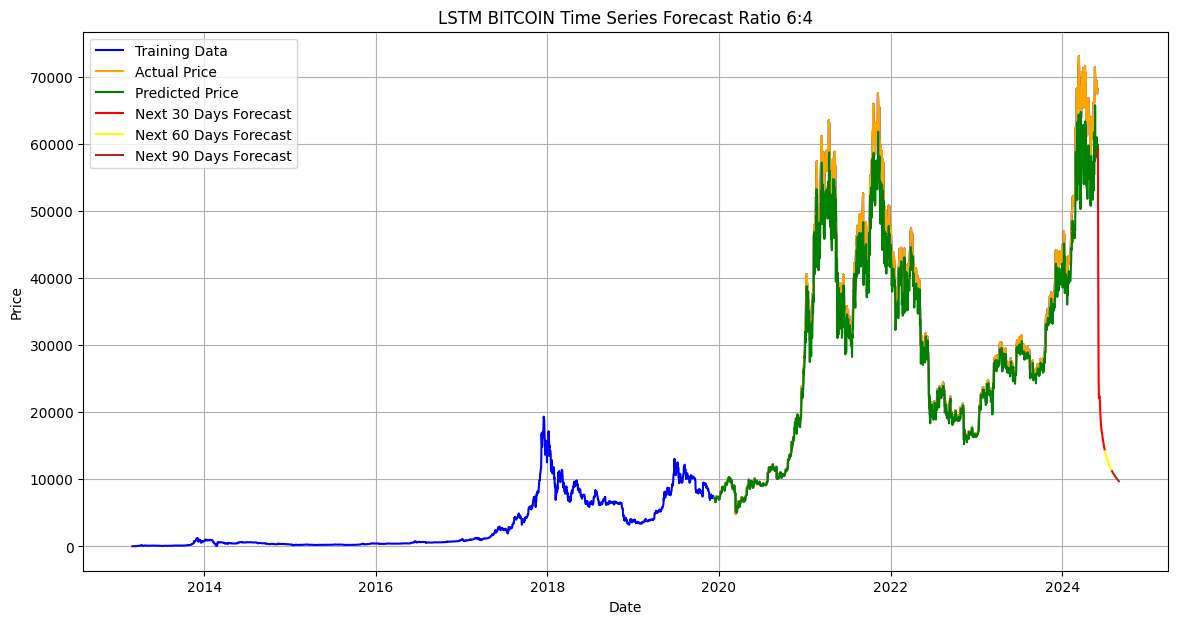

Testing MAE: 2170.0304
Testing RMSE: 3460.7071
Testing MAPE: 5.21%


In [16]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [0.00137063]
 [0.00150208]
 [0.00143636]
 [0.00112416]
 [0.00098587]
 [0.00087359]
 [0.00107624]
 [0.00111869]
 [0.00106802]
 [0.00103105]
 [0.00108035]
 [0.00107487]
 [0.00114197]
 [0.00111321]
 [0.00110226]
 [0.00114607]
 [0.0010557 ]
 [0.00109404]
 [0.00114881]
 [0.00122138]
 [0.00121727]
 [0.00120769]
 [0.00120084]
 [0.00121317]
 [0.00122549]
 [0.00125972]
 [0.00135283]
 [0.00133777]
 [0.00135831]
 [0.00130765]
 [0.00129669]
 [0.00134188]
 [0.00129395]
 [0.00129395]
 [0.0013008 ]
 [0.00120769]
 [0.00118304]
 [0.00119263]
 [0.00119947]
 [0.00115977]
 [0.00105022]
 [0.00100778]
 [0.00090508]
 [0.00098587]
 [0.00102284]
 [0.0010201 ]
 [0.00095301]
 [0.00089961]
 [0.00089687]
 [0.00089824]
 [0.00092562]
 [0.00099956]
 [0.00101325]
 [0.00105433]
 [0.00102969]
 [0.00101189]
 [0.00100778]
 [0.00092836]
 [0.00094479]
 [0.00095438]
 [0.00092288]
 [0.00082703]
 [0.00083114]
 [0.00086537]
 [0.00073666]
 [0.00076816]
 [0.00061069]
 [0.0006257

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]
  ...
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[9.56257531e-01]
  [9.52694709e-01]
  [9.76252875e-01]
  ...
  [8.82665133e-01]
  [8.72659930e-01]
  [8.68420692e-01]]

 [[9.52694709e-01]
  [9.76252875e-01]
  [9.53419049e-01]
  ...
  [8.72659930e-01]
  [8.68420692e-01]
  [8.63667981e-01]]

 [[9.76252875e-01]
  [9.53419049e-01]
  [8.95564958e-01]
  ...
  [8.68420692e-01]
  [8.63667981e-01]
  [8.73942929e-01]]] [[8.03757257e-04]
 [9.54376164e-04]
 [1.14607295e-03]
 ...
 [8.63667981e-01]
 [8.73942929e-01]
 [8.30215522e-01]]
[[[2.73852558e-06]
  [0.00000000e+00]
  [2.73852558e-06]
  ...
  [7.10647387e-04]
  [7.69525687e-04]
  [7.92803155e-04]]

 [[0.00000000e+00]
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]


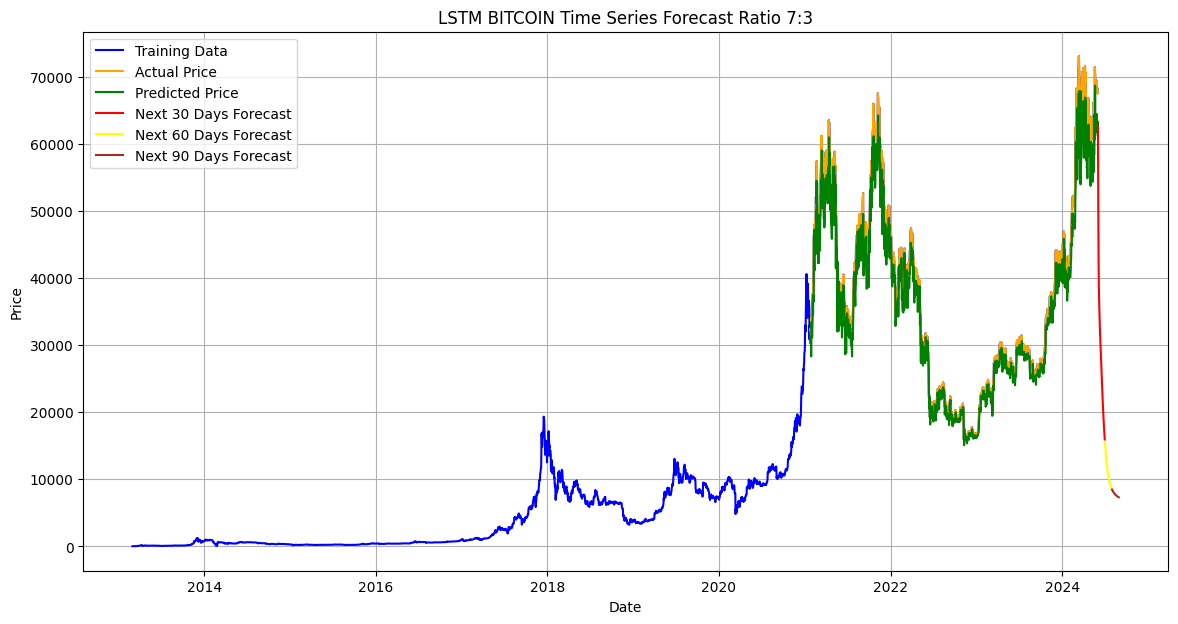

Testing MAE: 2180.2678
Testing RMSE: 2973.9660
Testing MAPE: 5.15%


In [17]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.00076816]
 [0.00061069]
 [0.00062575]
 [0.00046829]
 [0.00048472]
 [0.00057783]
 [0.00057098]
 [0.00058057]
 [0.00073529]
 [0.00074899]
 [0.00081745]
 [0.00087633]
 [0.00082293]
 [0.00088454]
 [0.0008599 ]
 [0.00087907]
 [0.00076405]
 [0.00079006]
 [0.00075994]
 [0.00079006]
 [0.00078459]
 [0.00083936]
 [0.00083251]
 [0.00085716]
 [0.00084484]
 [0.00082293]
 [0.00088317]
 [0.00092014]
 [0.00100915]
 [0.0009845 ]
 [0.00095438]
 [0.00096122]
 [0.0009667 ]
 [0.00096944]
 [0.00099135]
 [0.00098998]
 [0.00098176]
 [0.00094205]
 [0.00093795]
 [0.00094068]
 [0.00096807]
 [0.00099272]
 [0.00103105]
 [0.00107213]
 [0.00103653]
 [0.00102284]
 [0.00107487]
 [0.00108309]
 [0.00115292]
 [0.00118989]
 [0.00121864]
 [0.00120084]
 [0.00115292]
 [0.00116798]
 [0.00120221]
 [0.00117483]
 [0.00132818]
 [0.00129395]
 [0.0013008 ]
 [0.00141993]
 [0.001461  ]
 [0.00152947]
 [0.00150208]
 [0.00150208]
 [0.00134462]
 [0.00131312]
 [0.00119947]
 [0.0012966

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [9.06325994e-01]
  [8.92714153e-01]]

 [[8.68757531e-01]
  [8.73107679e-01]
  [8.89018512e-01]
  ...
  [9.06325994e-01]
  [8.92714153e-01]
  [9.17440300e-01]]] [[8.03757257e-04]
 [9.54376164e-04]
 [1.14607295e-03]
 ...
 [8.92714153e-01]
 [9.17440300e-01]
 [9.15806770e-01]]
[[[2.73852558e-06]
  [0.00000000e+00]
  [2.73852558e-06]
  ...
  [7.10647387e-04]
  [7.69525687e-04]
  [7.92803155e-04]]

 [[0.00000000e+00]
  [2.73852558e-06]
  [2.60159930e-05]
  ...
  [7.69525687e-04]
  [7.92803155e-04]
  [8.03757257e-04]]

 [[2.73852558e-06]
  [2.60159930e-05]
  [8.21557673e-05]
  ...
  [7.92803155e-04]
  [8.03757257e-04]
  [9.54376164e-04]]

 ...

 [[8.38599518e-01]
  [8.68757531e-01]
  [8.73107679e-01]
  ...
  [8.42577226e-01]
  [9.06325994e-01]
  [8.92714153e-01]]

 [[8.68757531e-01]
  [8.73107679e-01]
  [8.89018512e-01]
  ...
  [9.06325994e-01]
  [8.92714153e-01]
  [9.17440300e-01]]

 [[8.73107679e-01]
  [8.89018512e-01]
  [8.88732337e-01]


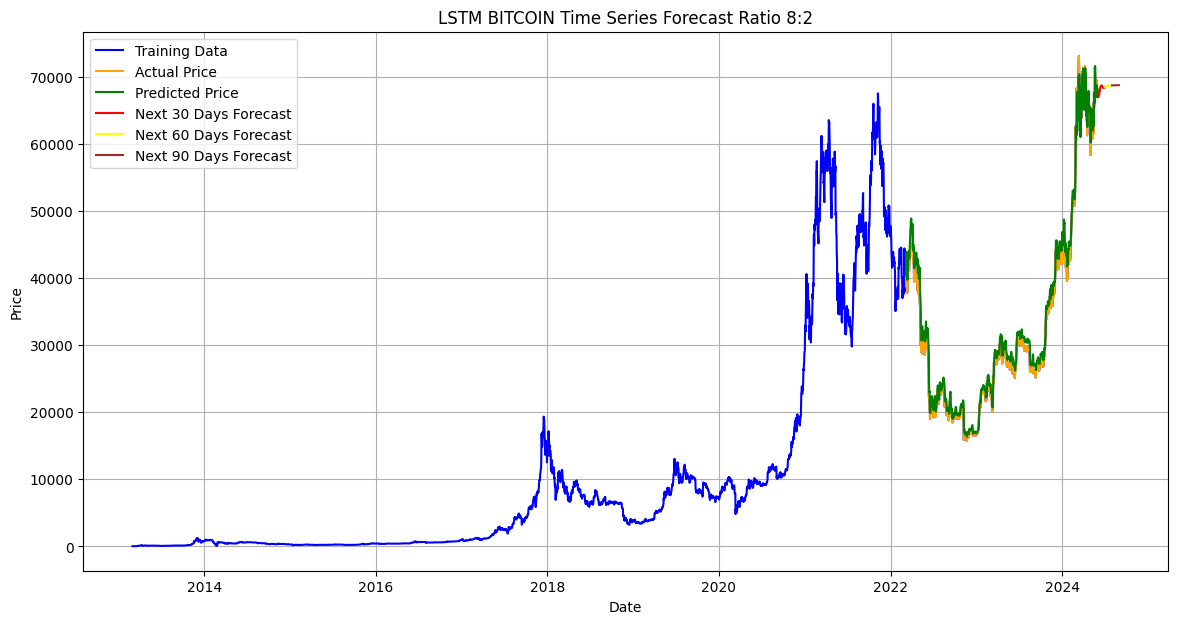

Testing MAE: 1226.9583
Testing RMSE: 1570.9673
Testing MAPE: 3.80%


In [18]:
results = process_dataset(bitcoin_df, "BITCOIN", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# NASDAQ

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.        ]
 [0.0028657 ]
 [0.00485003]
 [0.00743277]
 [0.00745587]
 [0.00892409]
 [0.00814955]
 [0.01015338]
 [0.01172482]
 [0.00958385]
 [0.01257875]
 [0.01532246]
 [0.01635758]
 [0.01662177]
 [0.01782291]
 [0.01752695]
 [0.01950551]
 [0.01966504]
 [0.02138446]
 [0.02203483]
 [0.0215743 ]
 [0.02400906]
 [0.02382571]
 [0.02423644]
 [0.02143426]
 [0.02115419]
 [0.02113398]
 [0.02328145]
 [0.02173888]
 [0.02345541]
 [0.02090083]
 [0.02158368]
 [0.02013207]
 [0.01697186]
 [0.01860105]
 [0.02186159]
 [0.02219003]
 [0.01953222]
 [0.01689607]
 [0.02013929]
 [0.01856568]
 [0.02062797]
 [0.02279709]
 [0.01998337]
 [0.01431261]
 [0.01377917]
 [0.01114518]
 [0.01310353]
 [0.0151485 ]
 [0.01699929]
 [0.01709963]
 [0.01935465]
 [0.01927597]
 [0.0200173 ]
 [0.02259498]
 [0.02298838]
 [0.02439091]
 [0.02558195]
 [0.0297354 ]
 [0.03130757]
 [0.03184245]
 [0.03119352]
 [0.03202363]
 [0.03211603]
 [0.03040743]
 [0.03132994]
 [0.02980542]
 [0.0298292

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]
  [3.61857492e-03]
  [7.09350403e-03]]

 ...

 [[9.33016302e-01]
  [9.46227385e-01]
  [9.41360030e-01]
  ...
  [9.48515612e-01]
  [9.38678401e-01]
  [9.58300851e-01]]

 [[9.46227385e-01]
  [9.41360030e-01]
  [9.22020541e-01]
  ...
  [9.38678401e-01]
  [9.58300851e-01]
  [9.39019830e-01]]

 [[9.41360030e-01]
  [9.22020541e-01]
  [9.28657843e-01]
  ...
  [9.58300851e-01]
  [9.39019830e-01]
  [9.18081470e-01]]] [[0.00361857]
 [0.0070935 ]
 [0.00276536]
 ...
 [0.93901983]
 [0.91808147]
 [0.9166544 ]]
[[[2.43981313e-04]
  [1.13112047e-03]
  [4.17005931e-03]
  ...
  [9.44814026e-03]
  [9.65819517e-03]
  [9.28211747e-03]]

 [[1.13112047e-03]
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]

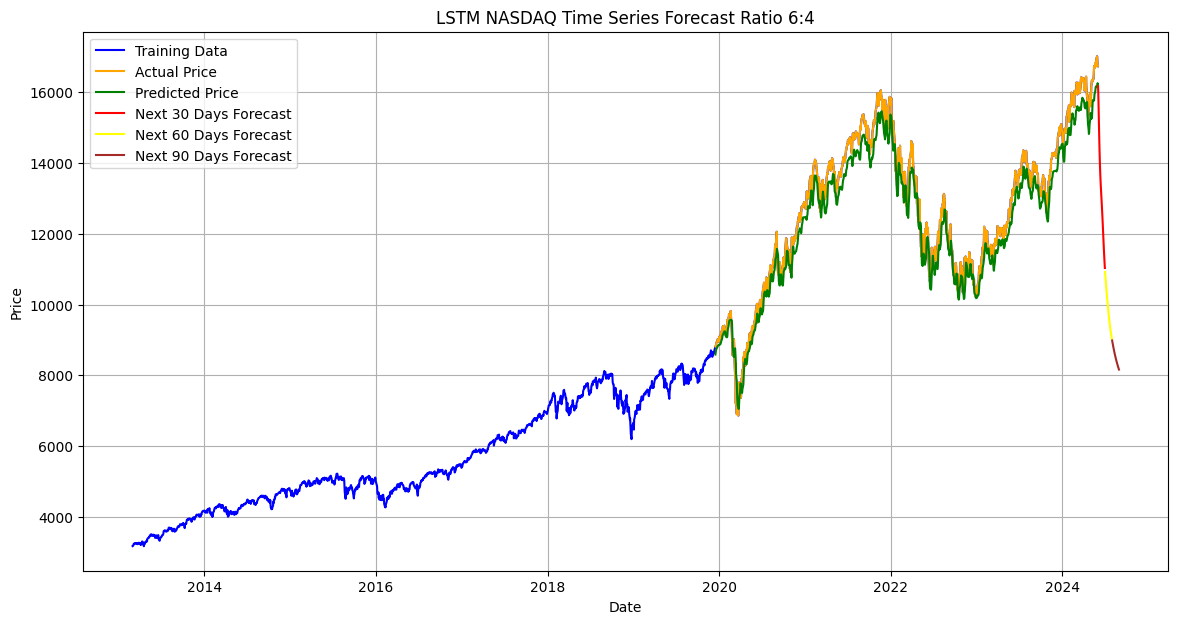

Testing MAE: 411.9028
Testing RMSE: 472.8487
Testing MAPE: 3.19%


In [19]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [0.08563022]
 [0.08788597]
 [0.08564466]
 [0.08580419]
 [0.08435473]
 [0.0869483 ]
 [0.08914485]
 [0.08827287]
 [0.09151176]
 [0.09287459]
 [0.09373574]
 [0.09686708]
 [0.09825301]
 [0.09817866]
 [0.09858433]
 [0.09904992]
 [0.10040697]
 [0.1013663 ]
 [0.10129267]
 [0.10043151]
 [0.10206143]
 [0.10335496]
 [0.10150489]
 [0.10076356]
 [0.10225127]
 [0.10292835]
 [0.100041  ]
 [0.10251257]
 [0.10289443]
 [0.10114686]
 [0.0976315 ]
 [0.10007565]
 [0.10075634]
 [0.10301136]
 [0.10202678]
 [0.098266  ]
 [0.09689451]
 [0.10025322]
 [0.09386712]
 [0.09714715]
 [0.09668951]
 [0.0957901 ]
 [0.09064339]
 [0.09122808]
 [0.09450739]
 [0.09300452]
 [0.08798053]
 [0.09399994]
 [0.08748535]
 [0.08011538]
 [0.07559812]
 [0.07657332]
 [0.07571794]
 [0.07586736]
 [0.07883051]
 [0.08299046]
 [0.09045499]
 [0.0878109 ]
 [0.09285943]
 [0.09509208]
 [0.0952516 ]
 [0.10090793]
 [0.09982084]
 [0.10104147]
 [0.10570454]
 [0.10629428]
 [0.10519204]
 [0.1049812

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [9.51375535e-01]
  [9.50986464e-01]]] [[0.00361857]
 [0.0070935 ]
 [0.00276536]
 ...
 [0.95137553]
 [0.95098646]
 [0.95440581]]
[[[2.43981313e-04]
  [1.13112047e-03]
  [4.17005931e-03]
  ...
  [9.44814026e-03]
  [9.65819517e-03]
  [9.28211747e-03]]

 [[1.13112047e-03]
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]
  [3.61857492e-03]
  [7.09350403e-03]]

 ...

 [[9.53772038e-01]
  [9.55025871e-01]
  [9.43737765e-01]
  ...
  [9.50385895e-01]
  [9.48235539e-01]
  [9.51375535e-01]]

 [[9.55025871e-01]
  [9.43737765e-01]
  [9.46409288e-01]
  ...
  [9.48235539e-01]
  [9.51375535e-01]
  [9.50986464e-01]]

 [[9.43737765e-01]
  [9.46409288e-01]
  [9.29923947e-01]
  ...
  [9.51375535e-01]
  [9.50986464e-01]
  [9.54405812e-01]]] [[0.00361857]
 [0.0070935 ]
 [0.00276536]
 ...
 [0.95098646]
 [0.95440581]
 [0.96

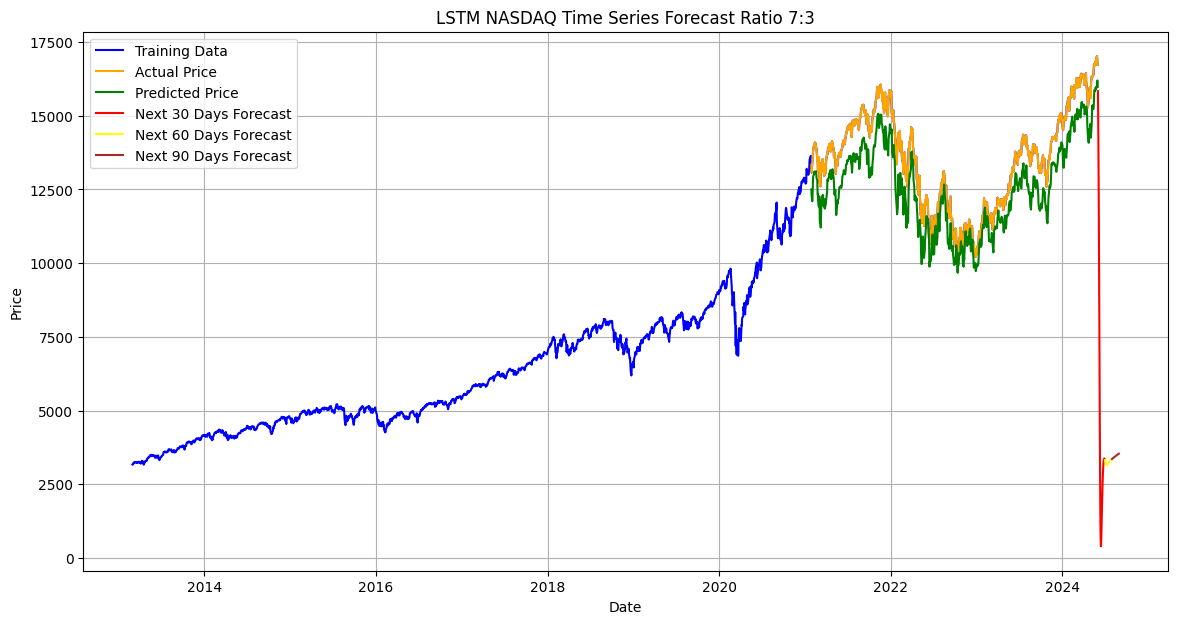

Testing MAE: 976.8962
Testing RMSE: 1046.0353
Testing MAPE: 7.13%


In [20]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]
  [3.61857492e-03]
  [7.09350403e-03]]

 ...

 [[9.38420705e-01]
  [9.53046590e-01]
  [9.55387512e-01]
  ...
  [9.21176712e-01]
  [9.25159815e-01]
  [9.01681306e-01]]

 [[9.53046590e-01]
  [9.55387512e-01]
  [9.57335031e-01]
  ...
  [9.25159815e-01]
  [9.01681306e-01]
  [8.97903204e-01]]

 [[9.55387512e-01]
  [9.57335031e-01]
  [9.54133679e-01]
  ...
  [9.01681306e-01]
  [8.97903204e-01]
  [9.14901050e-01]]] [[0.00361857]
 [0.0070935 ]
 [0.00276536]
 ...
 [0.8979032 ]
 [0.91490105]
 [0.93766566]]
[[[2.43981313e-04]
  [1.13112047e-03]
  [4.17005931e-03]
  ...
  [9.44814026e-03]
  [9.65819517e-03]
  [9.28211747e-03]]

 [[1.13112047e-03]
  [4.17005931e-03]
  [4.04301578e-03]
  ...
  [9.65819517e-03]
  [9.28211747e-03]
  [3.61857492e-03]]

 [[4.17005931e-03]
  [4.04301578e-03]
  [4.74464252e-03]
  ...
  [9.28211747e-03]
  [3.61857492e-03]
  [7.09350403e-03]]

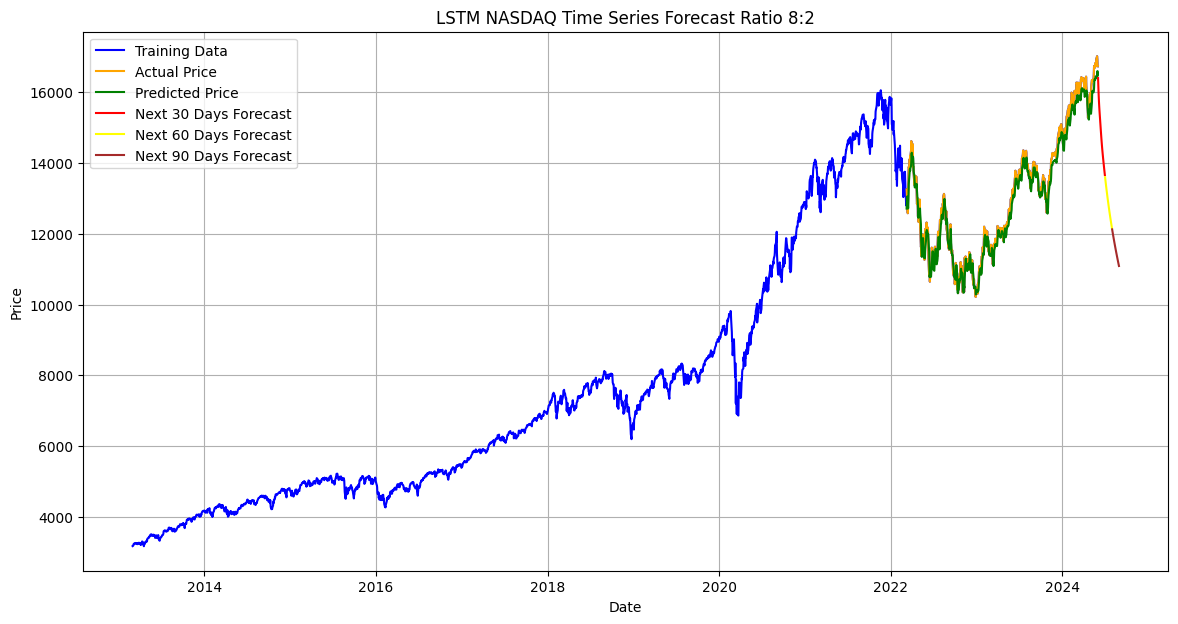

Testing MAE: 223.8990
Testing RMSE: 268.4157
Testing MAPE: 1.70%


In [21]:
results = process_dataset(nasdaq_df, "NASDAQ", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# US Dollar

# RATIO 6:4

Streaming output truncated to the last 5000 lines.
 [0.49448756]
 [0.5291372 ]
 [0.52844993]
 [0.55808826]
 [0.59159245]
 [0.58088256]
 [0.60674093]
 [0.58291572]
 [0.59628877]
 [0.56284184]
 [0.5858366 ]
 [0.54537384]
 [0.52037456]
 [0.5246127 ]
 [0.51748232]
 [0.53137081]
 [0.52673177]
 [0.54852381]
 [0.55940552]
 [0.55407921]
 [0.53111308]
 [0.50614244]
 [0.51072421]
 [0.5420807 ]
 [0.5442284 ]
 [0.58042439]
 [0.58618024]
 [0.59110564]
 [0.56739498]
 [0.55551101]
 [0.52942356]
 [0.53208671]
 [0.54505885]
 [0.54634747]
 [0.54442885]
 [0.52484179]
 [0.51467598]
 [0.51015148]
 [0.50093067]
 [0.47447095]
 [0.4572034 ]
 [0.47805046]
 [0.48440766]
 [0.47246642]
 [0.44119584]
 [0.45634432]
 [0.46230062]
 [0.46688239]
 [0.45388162]
 [0.42530283]
 [0.42049197]
 [0.41061253]
 [0.44236992]
 [0.4739555 ]
 [0.47876636]
 [0.47372641]
 [0.49674981]
 [0.49674981]
 [0.53423441]
 [0.53609576]
 [0.52426906]
 [0.52240772]
 [0.53669712]
 [0.49044987]
 [0.48002635]
 [0.47971135]
 [0.50428109]
 [0.4752154

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.70653761]
  [0.70593626]
  [0.70522035]
  ...
  [0.74181724]
  [0.74276223]
  [0.76475473]]

 [[0.70593626]
  [0.70522035]
  [0.69284957]
  ...
  [0.74276223]
  [0.76475473]
  [0.76950832]]

 [[0.70522035]
  [0.69284957]
  [0.67712838]
  ...
  [0.76475473]
  [0.76950832]
  [0.77142694]]] [[0.09681853]
 [0.07723147]
 [0.10495118]
 ...
 [0.76950832]
 [0.77142694]
 [0.76280748]]
[[[0.09255176]
  [0.08960225]
  [0.08650955]
  ...
  [0.10045531]
  [0.09160677]
  [0.09392629]]

 [[0.08960225]
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.70593626]
  [0.70522035]
  [0.69284957]
  ...
  [0.74276223]
  [0.76475473]
  [0.76950832]]

 [[0.70522035]
  [0.69284957]
 

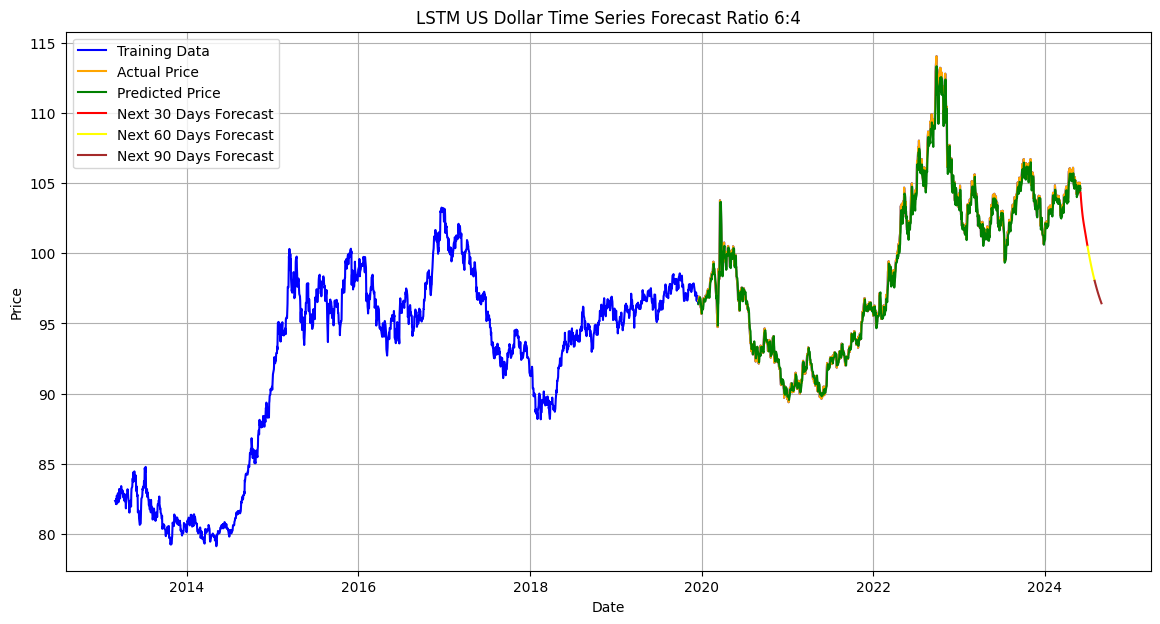

Testing MAE: 0.3835
Testing RMSE: 0.5146
Testing MAPE: 0.38%


In [22]:
results = process_dataset(usd_df, "US Dollar", 30, 0.6)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 7:3

Streaming output truncated to the last 5000 lines.
 [0.27043899]
 [0.26262135]
 [0.29208786]
 [0.2964119 ]
 [0.30683543]
 [0.30992812]
 [0.32072392]
 [0.31777441]
 [0.32026574]
 [0.32559205]
 [0.31937802]
 [0.3299161 ]
 [0.35099224]
 [0.35783626]
 [0.36115804]
 [0.37195384]
 [0.3858996 ]
 [0.37287019]
 [0.37392973]
 [0.383036  ]
 [0.37854013]
 [0.38607142]
 [0.39414679]
 [0.39414679]
 [0.40729074]
 [0.4013058 ]
 [0.43629908]
 [0.4560866 ]
 [0.45786203]
 [0.43309184]
 [0.44675124]
 [0.45488388]
 [0.45451161]
 [0.44695169]
 [0.41802927]
 [0.43065777]
 [0.41825835]
 [0.45030211]
 [0.44259901]
 [0.45035938]
 [0.45714613]
 [0.43160276]
 [0.43392228]
 [0.43392228]
 [0.43014232]
 [0.43329229]
 [0.44002176]
 [0.43566908]
 [0.44474671]
 [0.44199765]
 [0.43266229]
 [0.4641906 ]
 [0.46376106]
 [0.46828556]
 [0.4662524 ]
 [0.48280404]
 [0.49448756]
 [0.5291372 ]
 [0.52844993]
 [0.55808826]
 [0.59159245]
 [0.58088256]
 [0.60674093]
 [0.58291572]
 [0.59628877]
 [0.56284184]
 [0.5858366 ]
 [0.5453738

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 [[0.08960225]
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.73417142]
  [0.72838693]
  [0.71220755]
  ...
  [0.75312849]
  [0.74390768]
  [0.74594084]]

 [[0.72838693]
  [0.71220755]
  [0.70917213]
  ...
  [0.74390768]
  [0.74594084]
  [0.74387904]]

 [[0.71220755]
  [0.70917213]
  [0.71432662]
  ...
  [0.74594084]
  [0.74387904]
  [0.73783683]]] [[0.09681853]
 [0.07723147]
 [0.10495118]
 ...
 [0.74387904]
 [0.73783683]
 [0.71836431]]
[[[0.09255176]
  [0.08960225]
  [0.08650955]
  ...
  [0.10045531]
  [0.09160677]
  [0.09392629]]

 [[0.08960225]
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.72838693]
  [0.71220755]
  [0.70917213]
  ...
  [0.7439076

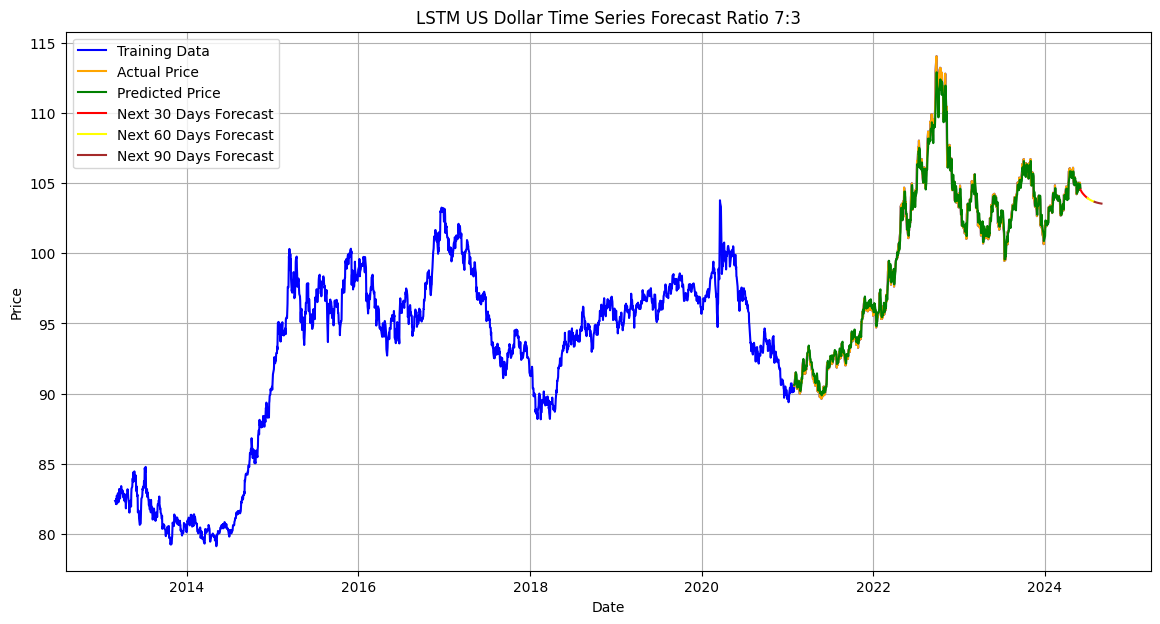

Testing MAE: 0.3701
Testing RMSE: 0.5021
Testing MAPE: 0.36%


In [23]:
results = process_dataset(usd_df, "US Dollar", 30, 0.7)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')

# RATIO 8:2

Streaming output truncated to the last 5000 lines.
 [0.47730592]
 [0.47730592]
 [0.44778214]
 [0.45130437]
 [0.45373844]
 [0.46181381]
 [0.45451161]
 [0.4704619 ]
 [0.46178517]
 [0.46066837]
 [0.48477993]
 [0.47636093]
 [0.48065634]
 [0.47175052]
 [0.46361788]
 [0.46364652]
 [0.45857793]
 [0.46121245]
 [0.46189972]
 [0.4659374 ]
 [0.46344606]
 [0.46923055]
 [0.48435039]
 [0.48417857]
 [0.50287792]
 [0.49964205]
 [0.50763151]
 [0.52936628]
 [0.53709802]
 [0.52438361]
 [0.5379571 ]
 [0.53469259]
 [0.5350935 ]
 [0.53646803]
 [0.54689156]
 [0.55783053]
 [0.55943415]
 [0.55742963]
 [0.55539647]
 [0.56307093]
 [0.54769337]
 [0.54998425]
 [0.5292231 ]
 [0.52140546]
 [0.51530598]
 [0.51235646]
 [0.53240171]
 [0.53403396]
 [0.55347785]
 [0.56063687]
 [0.56854042]
 [0.59932419]
 [0.60276052]
 [0.60771456]
 [0.62240486]
 [0.63205521]
 [0.62718708]
 [0.62684345]
 [0.64525644]
 [0.64525644]]
[[[0.09255176]
  [0.08960225]
  [0.08650955]
  ...
  [0.10045531]
  [0.09160677]
  [0.09392629]]

 [[0.08960

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.

 [[0.68497466]
  [0.70272902]
  [0.71736205]
  ...
  [0.75375848]
  [0.7724292 ]
  [0.75891298]]

 [[0.70272902]
  [0.71736205]
  [0.71040348]
  ...
  [0.7724292 ]
  [0.75891298]
  [0.74602675]]

 [[0.71736205]
  [0.71040348]
  [0.71203574]
  ...
  [0.75891298]
  [0.74602675]
  [0.73858137]]] [[0.09681853]
 [0.07723147]
 [0.10495118]
 ...
 [0.74602675]
 [0.73858137]
 [0.73861001]]
[[[0.09255176]
  [0.08960225]
  [0.08650955]
  ...
  [0.10045531]
  [0.09160677]
  [0.09392629]]

 [[0.08960225]
  [0.08650955]
  [0.09681853]
  ...
  [0.09160677]
  [0.09392629]
  [0.09681853]]

 [[0.08650955]
  [0.09681853]
  [0.08582228]
  ...
  [0.09392629]
  [0.09681853]
  [0.07723147]]

 ...

 [[0.70272902]
  [0.71736205]
  [0.71040348]
  ...
  [0.7724292 ]
  [0.75891298]
  [0.74602675]]

 [[0.71736205]
  [0.71040348]
  [0.71203574]
  ...
  [0.75891298]
  [0.74602675]
  [0.73858137]]

 [[0.71040348]
  [0.71203574]
  [0.71412617]
  ...
  [0.74602675]
  

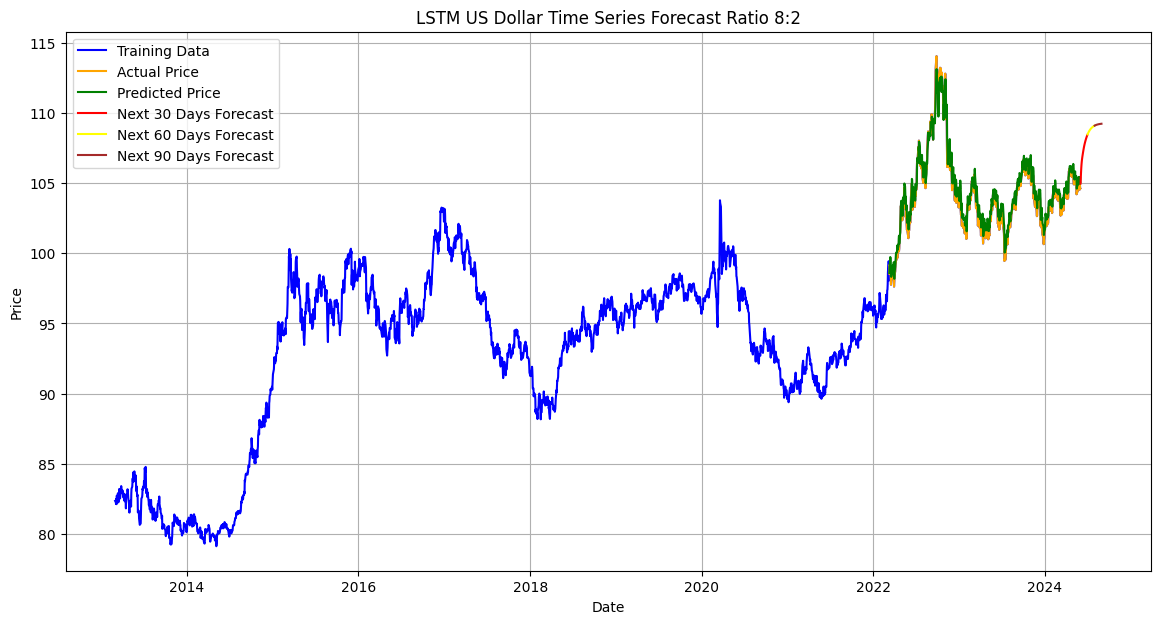

Testing MAE: 0.5374
Testing RMSE: 0.6686
Testing MAPE: 0.52%


In [24]:
results = process_dataset(usd_df, "US Dollar", 30, 0.8)
print(f'Testing MAE: {results["mae"]:.4f}')
print(f'Testing RMSE: {results["rmse"]:.4f}')
print(f'Testing MAPE: {results["mape"]:.2f}%')